<a href="https://colab.research.google.com/github/miguelsmachado/data_science/blob/master/previsoes_imobiliarias_Exercicio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### **Data Science**
*by [Miguel S. Machado](https://www.linkedin.com/in/miguel-machado-6655511a6/)*

---

# *Previsões sobre o preço de imóveis*

Uma hora na vida, todos teremos que escolher um lugar para morar. Quem já passou por essa experiência na vida sabe a dificuldade que é escolher uma casa ou um apartamento. Qualquer detalhe pode influenciar muito no preço, quantidade de quartos, vagas na garagem, localização etc.

Nosso objetivo aqui é fazer um modelo de Machine Learning que possa nos predizer o valor a ser pago em um imóvel de acordo com algumas características que o imóvel possua, ou não.

Para isso, vamos utilizar um dataset disponível no [Kaggle](https://www.kaggle.com/greenwing1985/housepricing/) que foi gerado por computador para treinamento de machine learning para iniciantes.

## Importando bibliotecas

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import warnings
warnings.filterwarnings(action='once')

## Conhecendo o DataFrame

###Importando o arquivo *.csv*

In [0]:
df = pd.read_csv("https://raw.githubusercontent.com/miguelsmachado/data_science/master/analise_de_imoveis/HousePrices_HalfMil.csv", sep=';')

###Visualizando e conhecendo os dados

In [7]:
df.head()

,precos,area,garagem,banheiros,lareira,marmore,andares
0,51875,25,3,4,3,0,1
1,17875,35,1,3,1,0,0
2,47075,195,2,4,2,0,0
3,38575,33,2,2,1,0,1
4,33775,11,2,3,0,0,1



### Dados:
<ul style='font-size: 18px; line-height: 2; text-align: justify;'>
    <li><b>precos</b> - Preços do imóveis</li>
    <li><b>area</b> - Área do imóvel</li>
    <li><b>garagem</b> - Número de vagas de garagem</li>
    <li><b>banheiros</b> - Número de banheiros</li>
    <li><b>lareira</b> - Número de lareiras</li>
    <li><b>marmore</b> - Se o imóvel possui acabamento em mármore branco (1) ou não (0)</li>
    <li><b>andares</b> - Se o imóvel possui mais de um andar (1) ou não (0)</li>
</ul>

####Tamanho do Dataset

In [9]:
print(f'Nosso dataset possui {df.shape[0]} entradas.')

Nosso dataset possui 1000 entradas.


##Análises Preliminares

### Estatísticas descritivas

Vamos usar uma funcionalidade do pandas para ver diversos valores, como média, mediana, distribuição e outros.

In [11]:
df.describe().round(2)

,precos,area,garagem,banheiros,lareira,marmore,andares
count,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
mean,41985.60,124.33,2.01,3.00,2.03,0.33,0.48
std,12140.39,72.39,0.81,1.43,1.42,0.47,0.50
min,13150.00,1.00,1.00,1.00,0.00,0.00,0.00
25%,33112.50,60.75,1.00,2.00,1.00,0.00,0.00
50%,41725.00,123.00,2.00,3.00,2.00,0.00,0.00
75%,51175.00,187.00,3.00,4.00,3.00,1.00,1.00
max,73675.00,249.00,3.00,5.00,4.00,1.00,1.00


Os dados gerados referente ao `marmore` e aos `andares`não nos trazem nenhum significado nessa tabela, pois seu significado é booleano.

Os demais valores apresentam, em príncipio, dados bem distribuidos, o que é muito bom para o uso em Machine Learning.

### Matriz de correlação

Uma outra análise importante que devemos fazer é a matriz de coorelação, seu valor varia entre -1 e 1, sendo que -1 indica associação negativa perfeita, +1 indica associação positiva perfeita e o 0 indica que as variáveis não possuem relacionamento entre si.

####Tabela

In [13]:
df.corr().round(3)

,precos,area,garagem,banheiros,lareira,marmore,andares
precos,1.000,0.118,0.103,0.124,0.107,0.431,0.632
area,0.118,1.000,-0.008,-0.011,0.012,-0.015,-0.018
garagem,0.103,-0.008,1.000,0.067,0.060,-0.016,-0.021
banheiros,0.124,-0.011,0.067,1.000,0.048,-0.025,-0.018
lareira,0.107,0.012,0.060,0.048,1.000,0.030,-0.004
marmore,0.431,-0.015,-0.016,-0.025,0.030,1.000,-0.007
andares,0.632,-0.018,-0.021,-0.018,-0.004,-0.007,1.000


####Gráfico

Text(0.5, 1.0, 'Matriz de Correlação')

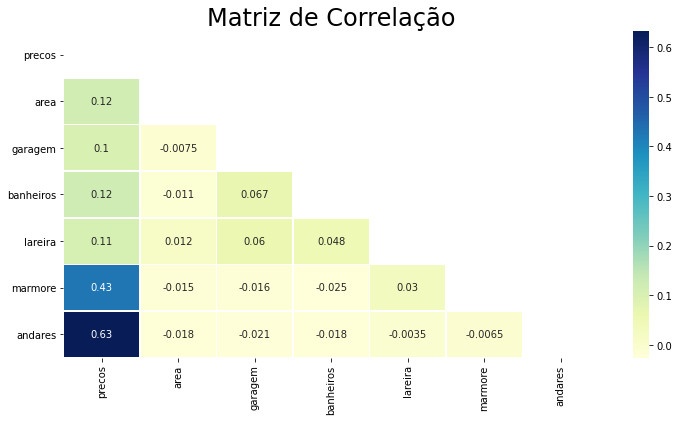

In [21]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(df.corr(), cmap='YlGnBu', annot=True, linewidths=.5, mask=mask)
ax.figure.set_size_inches(12,6)
ax.set_title('Matriz de Correlação', fontsize=24)

Nosso objetivo é estimar valores da preço dos imóveis, por isso, `precos` será noss variável dependente, enquanto o restante serão as variáveis explicativas.

Como podemos observar tanto na tabela, como no gráfico, a correlação do preço com as outras variáveis não é tão grande. Esse valor se mostra um pouco mais alto com `marmore` e `andares`.

Outra informação que devemos verificar é se existem variáveis explicativas com forte correlação, pois isso poderia prejudicar nosso modelo de Machine Learning, afinal estariamos dando "mais do mesmo" para ele!

## Comportamento da Variável Dependente (Y)

### Análises gráficas

![boxplot](https://github.com/miguelsmachado/data_science/blob/master/Airbnb/compressed_box-plot.png?raw=true)

Antes de iniciarmos vamos fazer umas configurações quando a cor e o estilo dos nossos gráficos:

In [0]:
sns.set_palette("Dark2")
sns.set_style("whitegrid")

#### Box plot da variável *dependente* (y)

Text(0, 0.5, 'Preços')

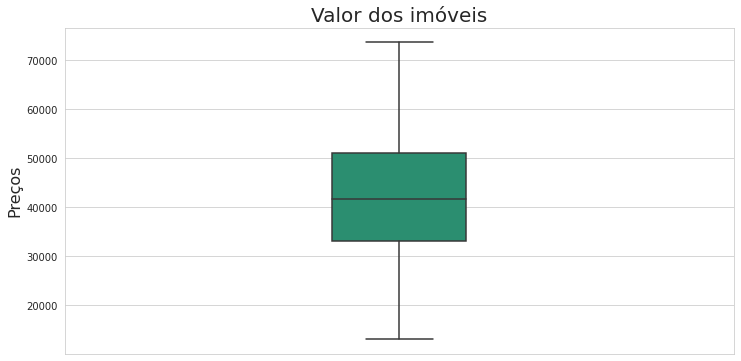

In [36]:
ax = sns.boxplot(df.precos, orient='v', width=0.2)
ax.figure.set_size_inches(12, 6)
ax.set_title("Valor dos imóveis", fontsize=20)
ax.set_ylabel('Preços', fontsize=16)

Confirmando o que já havimos levantado na análise descritiva, a distribuição dos valores do preço estão bem distribuídas.

#### Verificando a variável *dependente* (y) juntamente com outras característica

O objetivo é avaliar a distribuição da variável dependente com cada variável explicativa:
- As estatísticas apresentam mudança significativa entre as categorias?
- O box plot apresenta alguma tendência bem definida?

#### Box-plot (Preço X Garagem)

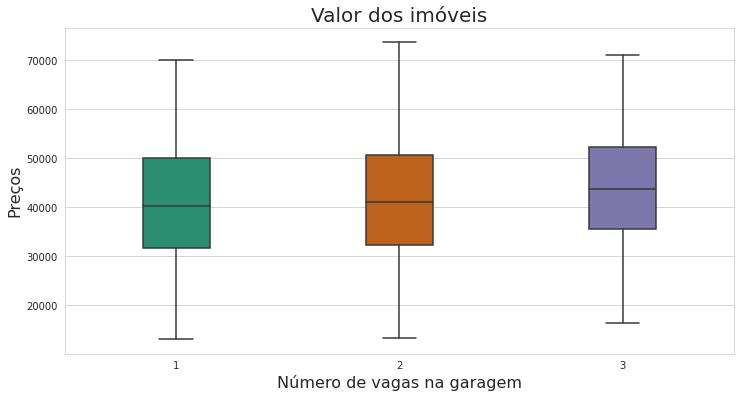

In [45]:
ax = sns.boxplot(data=df, x='garagem', y='precos', orient='v', width=0.3)
ax.figure.set_size_inches(12, 6)
ax.set_title("Valor dos imóveis", fontsize=20)
ax.set_ylabel('Preços', fontsize=16)
ax.set_xlabel('Número de vagas na garagem', fontsize=16);

#### Box-plot (Preço X Banheiros)

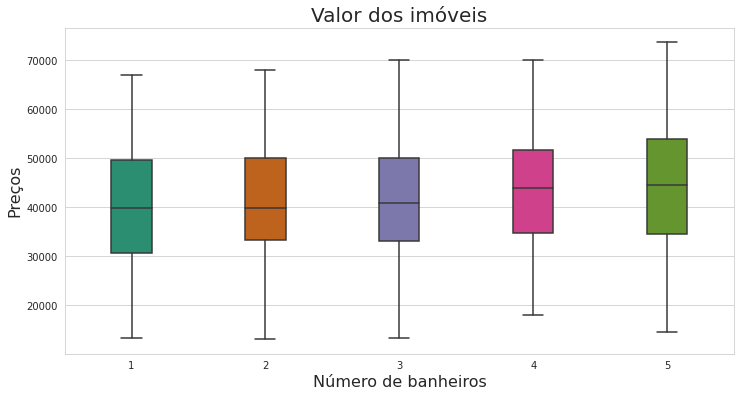

In [46]:
ax = sns.boxplot(data=df, x='banheiros', y='precos', orient='v', width=0.3)
ax.figure.set_size_inches(12, 6)
ax.set_title("Valor dos imóveis", fontsize=20)
ax.set_ylabel('Preços', fontsize=16);
ax.set_xlabel('Número de banheiros', fontsize=16);

#### Box-plot (Preço X Lareira)

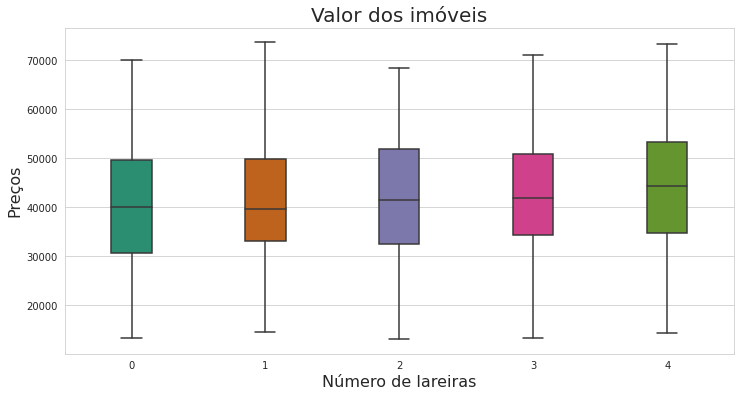

In [47]:
ax = sns.boxplot(data=df, x='lareira', y='precos', orient='v', width=0.3)
ax.figure.set_size_inches(12, 6)
ax.set_title("Valor dos imóveis", fontsize=20)
ax.set_ylabel('Preços', fontsize=16)
ax.set_xlabel('Número de lareiras', fontsize=16);

#### Box-plot (Preço X Acabamento em Mármore)

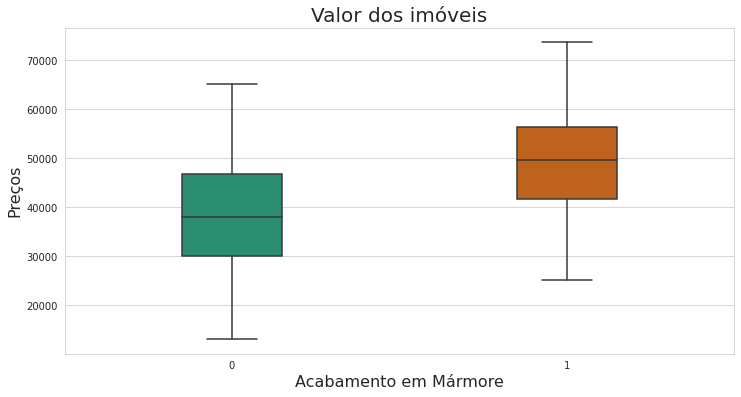

In [49]:
ax = sns.boxplot(data=df, x='marmore', y='precos', orient='v', width=0.3)
ax.figure.set_size_inches(12, 6)
ax.set_title("Valor dos imóveis", fontsize=20)
ax.set_ylabel('Preços', fontsize=16)
ax.set_xlabel('Acabamento em Mármore', fontsize=16);

#### Box-plot (Preço X Andares)

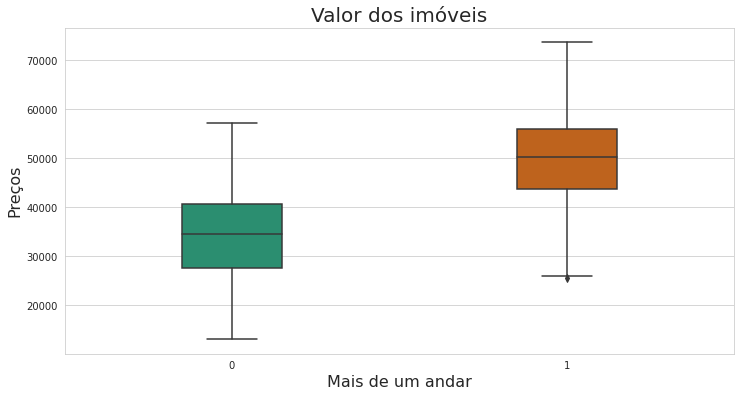

In [50]:
ax = sns.boxplot(data=df, x='andares', y='precos', orient='v', width=0.3)
ax.figure.set_size_inches(12, 6)
ax.set_title("Valor dos imóveis", fontsize=20)
ax.set_ylabel('Preços', fontsize=16)
ax.set_xlabel('Mais de um andar', fontsize=16);

#####**Confirmando a análise anterior, o valor do imóvel não sofre grandes variações com a mudando do valor da maioria das variáveis, exceto número de andar ou acabamento em marmore.**

## Distribuição de frequências da variável *dependente* (y)

### Vamos observar os seguintes aspectos:
- A distribuição de frequências da variável dependente parece ser assimétrica?
- É possível supor que a variável dependente segue uma distribuição normal?

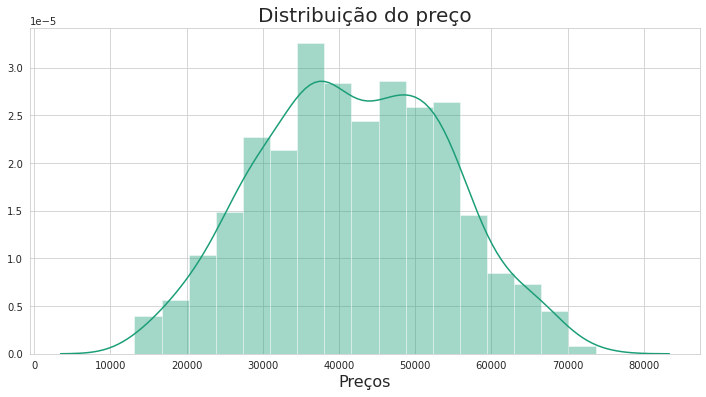

In [52]:
ax = sns.distplot(df.precos)
ax.figure.set_size_inches(12, 6)
ax.set_title("Distribuição do preço", fontsize=20)
ax.set_xlabel('Preços', fontsize=16);

#### Apesar de não apresentar uma curva no formato de sino perfeita, podemos dizer que a distribuição dos valor so preço é simetrica e possui um distribuição normal.

## Gráficos de dispersão entre as variáveis do dataset

###Plotando o pairplot fixando somente uma variável no eixo y

####Após a visualição do gráfico, vamos tentar entender algumas coisas:
- É possível identificar alguma relação linear entre as variáveis?
- A relação é positiva ou negativa?

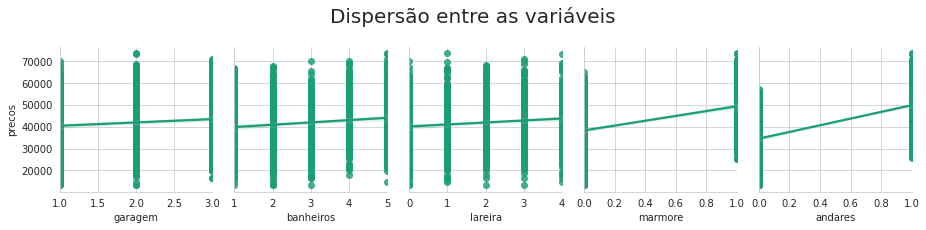

In [59]:
ax = sns.pairplot(data=df, x_vars=['garagem', 'banheiros', 'lareira', 'marmore', 'andares'], 
             y_vars=['precos'], kind='reg')
ax.fig.suptitle("Dispersão entre as variáveis", fontsize=20, y=1.2)
ax;

Em mais essa visualização, podemos confirmar que todas as variáveis possuem uma relação positiva, sendo mais forte a relação do preco com `marmore` e `andares`.

##Estimando um Modelo de Regressão Linear

### Criando uma Series para a variável dependente (y)

#### Conforme falado anteriormente, a variável dependente é o `precos`

In [0]:
y = df['precos']

### Criando uma Series para as variáveis explicativas (X)

#### Conforme falado anteriormente, as variáveis explicativas são `garagem`, `banheiros`, `lareira`, `marmore` e `andares`.

In [0]:
X = df[['garagem', 'banheiros', 'lareira', 'marmore', 'andares']]

### Criando os datasets de treino e de teste

#### Vamos utilizar *scikit-learn* para separar os valores do nosso Dataset em treino e teste, tanto de `X` como de `y`. Esses são os valores que serão treinados e testados para gerar o nosso modelo de Machine Learning.

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1802)

####Agora que temos nossos dataset de treinos e de testes, podemos seguir e criar nosso modelo de Machine Learning!

###Instanciando a classe *LinearRegression()*

In [0]:
modelo = LinearRegression()

### Utilizando o método *fit()*

#### Agora vamos colocar nosso modelo para treinar e aprender como funcionam as variações do preço em relação das variáveis explicativas.

In [0]:
modelo.fit(X_train, y_train);

### Obtendo o coeficiente de determinação (R²) do modelo estimado com os dados de TREINO
#### O valor de R² varia entre 0 e 1. Quanto mais próximo de 1, melhor o modelo está treinado. Vamos ver qual o nosso valor:

In [71]:
print(f"R² = {modelo.score(X_train, y_train).round(2)}")

R² = 0.63


#### Como nossas variáveis explicativas não possuem uma correlação forte com a variável independente, no coeficiente não ficou muito um número tão elevado.

### Gerando previsões para os dados de TESTE (X_test) utilizando o método *predict()*

#### Agora vamos criar as previsão, baseadas no que foi "treinado" para os modelos de teste.

In [0]:
y_previsto = modelo.predict(X_test)

### Obtendo o coeficiente de determinação (R²) para as previsões do nosso modelo

####Anteriormente, haviamos feito esse calculo para os dados de TREINO, agora vamos usar as previsão para estipular esse valor e comparar os dois.

In [73]:
print(f"R² previsto = {metrics.r2_score(y_test, y_previsto).round(2)}")

R² previsto = 0.62


#### Conforme o esperado, os valores de R² estão próximos.

##Obtendo Previsões Pontuais

### Criando um simulador simples

#### Agora que temos um modelo de Machine Learning treinado, vamos criar um simulador que posso calcular o valor de um imóvel baseado nas informações que passamos.

#### Vamos ver qual seria o valor de uma casa com 2 vagas na garagem, 4 banheiros, 1 lareira, sem acabamento em mármore e com mais de um andar:

In [79]:
# Informe a quantidade de vagas na garagem:
garagem = 2
# Informe a quantidade de banheiros:
banheiros = 4
# Informe a quantidade de lareiras:
lareira = 1
# Informe se a casa possui acabamento em marmore:
marmore = 0
# Informe se a casa possui mais de um andar:
andares = 1

# Criando a lista com os dados de entrada:
entrada = [[garagem, banheiros, lareira, marmore, andares]]

# Realizando a predição:
print(f"Uma casa com essas características custa R$ {modelo.predict(entrada)[0].round(2)}")

Uma casa com essas características custa R$ 46444.77


##Analise Gráfica das Previsões do Modelo

Agora vamos verificar como se comporta nosso modelo quando comparado com os dados reais

### Gerando previsões do modelo para os dados de treino

#### Antes de fazer a comparações, precisamos gerar essa previsão, pois ela que será a base para a comparação

In [0]:
y_previsto_train = modelo.predict(X_train)

###Gráfico de dispersão entre o valor estimado e o valor real

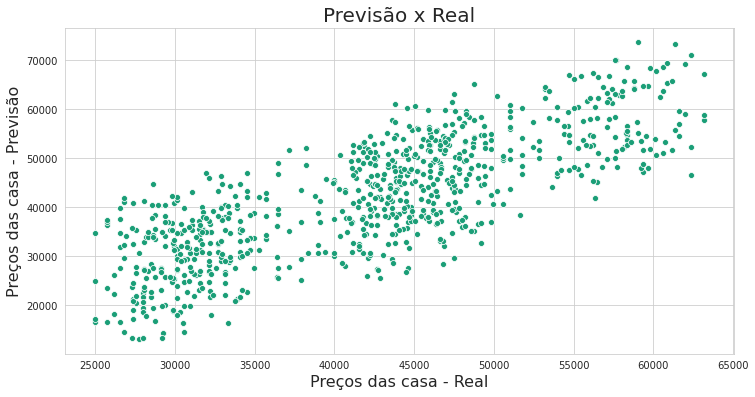

In [87]:
ax = sns.scatterplot(x=y_previsto_train, y=y_train)
ax.figure.set_size_inches(12,6)
ax.set_title('Previsão x Real', fontsize=20)
ax.set_ylabel('Preços das casa - Previsão', fontsize=16)
ax.set_xlabel('Preços das casa - Real', fontsize=16);

### Residuos

#### **Explicação de resíduos**

In [0]:
residuos = y_train - y_previsto_train

###Gráfico de dispersão entre o valor estimado e o valor real

####**Explicação do grafico**

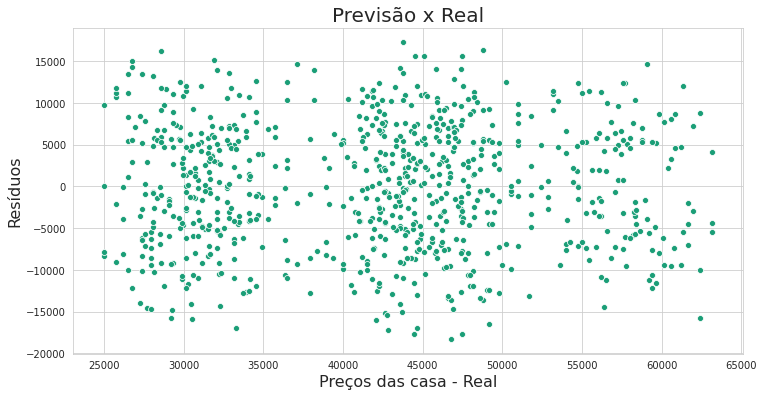

In [85]:
ax = sns.scatterplot(x=y_previsto_train, y=residuos)
ax.figure.set_size_inches(12,6)
ax.set_title('Previsão x Real', fontsize=20)
ax.set_ylabel('Resíduos', fontsize=16)
ax.set_xlabel('Preços das casa - Real', fontsize=16);

###Utilizando resíduos ao quadrado

####**Explicação do grafico**

![alt text](https://github.com/miguelsmachado/data_science/blob/master/analise_de_imoveis/var_u.jpg?raw=true://)

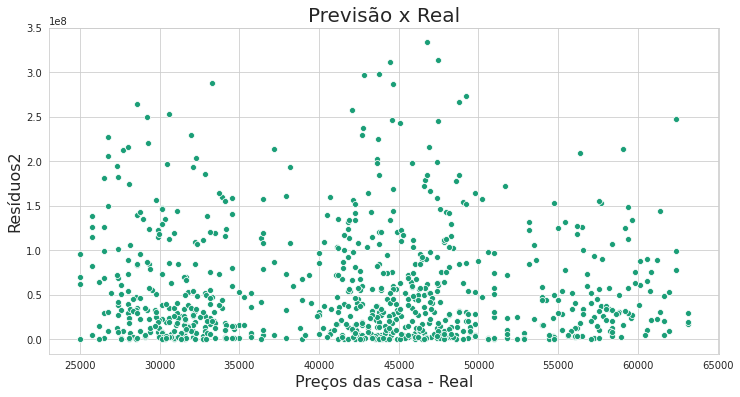

In [86]:
ax = sns.scatterplot(x=y_previsto_train, y=residuos**2)
ax.figure.set_size_inches(12,6)
ax.set_title('Previsão x Real', fontsize=20)
ax.set_ylabel('Resíduos2', fontsize=16)
ax.set_xlabel('Preços das casa - Real', fontsize=16);

### Distriduição dos Residuos

#### **Explicação**

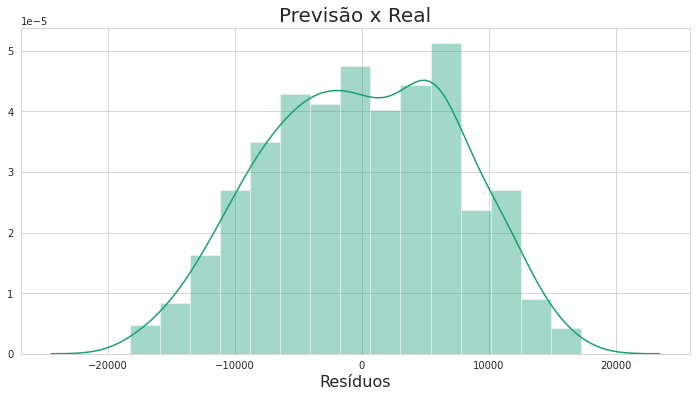

In [88]:
ax = sns.distplot(residuos)
ax.figure.set_size_inches(12,6)
ax.set_title('Previsão x Real', fontsize=20)
ax.set_xlabel('Resíduos', fontsize=16);

#**CONCLUSÃO**